# Experiments with dynamic mode decomposition (DMD) interpretation of place and grid cells

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

from types import SimpleNamespace
from tqdm import tqdm
from typing import Callable, Collection, Optional, Sequence
from contextlib import ExitStack

## Generic functions

In [2]:
def train(
    model: nn.Module,
    device: torch.device,
    loader: Collection,
    optimizer: torch.optim.Optimizer,
    progress: Optional[Callable] = tqdm,
    test_every: int = 1,
    test_set: Optional[Sequence] = None,
    scheduler: Optional[object] = None,
    scheduler_every: int = 1,
) -> SimpleNamespace:
    """A simple trainer for place/grid systems.

    This uses `model.loss` and automatic gradient calculation to optimize the model.

    :param model: the model to train
    :param device: device on which to train the model
    :param loader: data loader
        This can be any iterable returning triplets of `data`, `target`, and `shift`.
    :param optimizer: PyTorch optimizer for the model
    :param progress: progress bar callable -- must have the `tqdm` interface
    :param test_every: how often to call `test` function (in batches)
    :param test_set: data loader for test set
    :param scheduler: learning rate scheduler; must have `step` method
    :return: namespace containing:
        * train_loss:   loss curve on train set; one value for every batch
            (the following fields only if `test_set` is not `None`:)
        * test_loss:    loss curve on test set; one value every `test_every` batch
        * test_idxs:    batch indices where a test was performed
    """
    # send the model to the correct device
    model = model.to(device)

    # set the module in training mode
    model.train()

    # figure out total number of samples
    if hasattr(loader, "dataset"):
        n_total = len(loader.dataset)
        step = None
    else:
        n_total = len(loader)
        step = 1

    train_loss = []
    test_loss = []
    test_idxs = []

    batch_idx = 0

    with progress(
        total=n_total, postfix="loss: 0", mininterval=0.5
    ) if progress is not None else ExitStack() as pbar:
        for data, target, shift in loader:
            # ensure the tensors are on the right device
            data = data.to(device)
            target = target.to(device)

            # ensure parameters satisfy reality condition
            # XXX this is a bit hacky
            model.project_to_real()

            # start gradient calculation by first setting all of them to zero
            optimizer.zero_grad()

            # run the network and calculate the loss
            loss = model.loss(data, target, shift)
            train_loss.append(loss.item())

            # back-propagate to find gradients
            loss.backward()

            # update parameters
            optimizer.step()
            
            # update progress bar
            if progress is not None:
                pbar.postfix = f"train batch loss: {loss.item():.6f}"
                pbar.update(len(data) if step is None else step)
            
            # test on test set, if any given
            if test_set is not None and batch_idx % test_every == 0:
                l = test(model, device, test_set, progress=None)
                test_loss.append(l)
                test_idxs.append(batch_idx)
            
            # adjust step size, if scheduler given
            if scheduler is not None:
                scheduler.step()
            
            # keep batch index sync'd up
            batch_idx += 1

    res = SimpleNamespace(train_loss=train_loss)
    if test_set is not None:
        res.test_loss = test_loss
        res.test_idxs = test_idxs

    return res

In [3]:
def test(
    model: nn.Module,
    device: torch.device,
    loader: Collection,
    progress: Optional[Callable] = tqdm,
) -> float:
    """A simple tester for place/grid systems.

    This uses `model.loss`.

    :param model: the model to test
    :param device: device on which to test the model
    :param loader: data loader
        This can be any iterable returning triplets of `data`, `target`, and `shift`.
    :param progress: progress bar callable -- must have the `tqdm` interface
    :return: mean loss per batch on test set
    """
    # send the model to the correct device
    model = model.to(device)

    # set the module in evaluation mode
    model.eval()

    # figure out total number of samples
    if hasattr(loader, "dataset"):
        n_total = len(loader.dataset)
        step = None
    else:
        n_total = len(loader)
        step = 1

    # initialize loss tracker
    total_loss = 0
    count = 0

    with torch.no_grad():
        with progress(
            total=n_total, postfix="loss: 0", mininterval=0.5
        ) if progress is not None else ExitStack() as pbar:
            for data, target, shift in loader:
                # ensure the tensors are on the right device
                data = data.to(device)
                target = target.to(device)

                # run the network and calculate the loss
                loss = model.loss(data, target, shift)

                # keep track of loss and total samples
                total_loss += loss.item()
                count += 1

                # update progress bar
                if progress is not None:
                    pbar.postfix = f"test batch loss: {loss.item():.6f}"
                    pbar.update(len(data) if step is None else step)

    avg_loss = total_loss / count

    return avg_loss

In [4]:
class StepwiseScheduler:
    def __init__(self, optimizer, sequence: Sequence):
        assert len(optimizer.param_groups) == 1

        self.optimizer = optimizer
        self.sequence = np.copy(sequence)
        self._borders = np.cumsum([_[0] for _ in self.sequence])

        self._step_count = 0
        self._last_lr = None

        self.step()
    
    def get_last_lr(self) -> list:
        return self._last_lr

    def get_lr(self) -> list:
        mask = self._step_count <= self._borders
        if not np.any(mask):
            lr = [self.sequence[-1][1]]
        else:
            idx = mask.nonzero()[0][0]
            lr = [self.sequence[idx][1]]
        
        return lr
    
    def step(self):
        self._step_count += 1
        lr = self.get_lr()
        for group, crt_lr in zip(self.optimizer.param_groups, lr):
            group["lr"] = crt_lr
        
        self._last_lr = [group["lr"] for group in self.optimizer.param_groups]

## Dynamical systems

In [5]:
class PlaceGridMotionSimulator:
    """ A simple implementation of motion on a place grid with periodic boundary
    conditions.
    """
    def __init__(self, n: int, x0: Optional[float] = None, sigma: float = 2.0):
        """ Initialize the motion simulator.

        :param n: number of place cells
        :param x0: initial position; default: `n / 2`
        :param sigma: standard deviation of Gaussian place field
        """
        self.n = n
        self.x = x0 if x0 is not None else self.n / 2
        self.sigma = sigma

        # generate a zero-centered bump, using von Mises distribution
        self._kappa = (self.sigma * 2 * np.pi / self.n) ** (-2)
        self._centers = torch.linspace(0, 2 * np.pi, self.n) + np.pi / self.n
        self._prefactor = 1 / (2 * np.pi * torch.i0(torch.FloatTensor([self._kappa])))

        exponents = self._kappa * torch.cos(self._centers)
        self._bump = self._prefactor * torch.exp(exponents)

        # generate matrices for Fourier transform
        self._fourier_U = np.array(
            [
                [1 / np.sqrt(n) * np.exp(2 * np.pi * k * l / n * 1j) for k in range(n)]
                for l in range(n)
            ]
        )
        self._fourier_V = self._fourier_U.conj().T
    
    def __call__(self) -> torch.Tensor:
        """ Generate current place-cell activation vector. """
        # first move bump coarsely, according the integer part of x
        bump = torch.roll(self._bump, int(self.x))

        # then move finely, using Fourier transform
        bump = self._fourier_shift(bump, self.x - int(self.x))
        return bump
    
    def move(self, s: float):
        """ Shift current position by `s`. """
        self.x = (self.x + s) % self.n

    def batch(self, s: torch.Tensor):
        """ Generate place-cell activation vectors while moving according to a given
        sequence of shifts.

        :param s: sequence of shifts
        :return: tensor of activation vectors, shape `(len(s), self.n)`
        """
        res = torch.zeros(len(s), self.n)
        for i, crt_s in enumerate(s):
            res[i, :] = self()
            self.move(crt_s.item())
        
        return res

    def _fourier_shift(self, x: torch.Tensor, s: float) -> np.ndarray:
        """ Shift a vector using Fourier transform. """
        # turns out the ** operator has the right branch cut to make this work
        lbd = np.exp(-(2j * np.pi / self.n) * np.arange(self.n)) ** s

        # need to zero out highest frequency mode if n is even
        if self.n % 2 == 0:
            lbd[self.n // 2] = 0

        x_f = self._fourier_V @ x.detach().numpy()
        x_f_shifted = lbd * x_f
        x_shifted = self._fourier_U @ x_f_shifted
        
        assert np.max(np.abs(x_shifted.imag)) < 1e-6

        return torch.from_numpy(x_shifted.real)

## Network models

In [6]:
class PlaceGridSystemNonBioCplx:
    """ A complex-number based, non-biological implementation of our place&grid cell
    system.
    """
    def __init__(self, n: int, m: int):
        """ Initialize the system.
    
        :param n: number of place cells
        :param m: number of grid cells; if it is even, all eigenvalues and eigenvectors
                  come in complex-conjugate pairs; otherwise, the first eigenvalue and
                  eigenvector are real and non-negative, and real, respectively.
        """
        # assert m % 2 == 0

        self.n = n
        self.m = m

        rnd_scale = 0.1

        m_half = m // 2
        U_half = (
            torch.eye(n, m_half) + 
            rnd_scale * torch.view_as_complex(torch.normal(torch.zeros(n, m_half, 2)))
        )
        V_half = (
            torch.eye(m_half, n) +
            rnd_scale * torch.view_as_complex(torch.normal(torch.zeros(m_half, n, 2)))
        )
        lbd_half = (
            1 +
            rnd_scale * torch.view_as_complex(torch.normal(torch.zeros(m_half, 2)))
        )

        # the largest even number smaller equal to m
        me = 2 * m_half
        self.U = torch.stack((U_half, U_half.conj()), dim=2).view(n, me).contiguous()
        self.V = torch.stack((V_half, V_half.conj()), dim=1).view(me, n).contiguous()
        self.lbd = torch.stack((lbd_half, lbd_half.conj()), dim=1).view(me).contiguous()
        
        if m % 2 == 1:
            # add the real eigenvalue & eigenvector
            self.U = torch.hstack((torch.normal(torch.zeros(n, 1)), self.U))
            self.V = torch.vstack((torch.normal(torch.zeros(1, n)), self.V))
            self.lbd = torch.hstack((torch.FloatTensor([1.0]), self.lbd))

        self.U.requires_grad = True
        self.V.requires_grad = True
        self.lbd.requires_grad = True
    
    def to_grid(self, x: torch.Tensor) -> torch.Tensor:
        """ Convert batch of inputs to grid basis.

        This multiplies by `U`.

        :param x: tensor to transform; first dimension: batch index
        :return: transformed tensor
        """
        return (x + 0j) @ self.U

    def from_grid(
        self, z: torch.Tensor, atol=1e-4, rtol=1e-2, return_real: bool = True
    ) -> torch.Tensor:
        """ Convert batch of grid responses to place basis.

        This multiplies by `V`, ensures that the imaginary part is close to zero (and
        raises assertion otherwise), and converts to real.

        The imaginary part is checked to obey
            |imag| <= atol + rtol * |abs| ,
        where |abs| is the complex magnitude.

        :param z: tensor to transform; first dimension: batch index
        :param atol: absolute tolerance for imaginary part of output
        :param rtol: relative tolerance for imaginary part of output
        :param return_real: if `False`, it returns the full, complex-valued tensor
        :return: transformed tensor
        """
        y_pred = z @ self.V

        if return_real:
            max_abs_imag = torch.max(torch.abs(torch.imag(y_pred)))
            max_rel_imag = torch.max(
                torch.abs(torch.imag(y_pred)) / (torch.abs(y_pred) + 1e-12)
            )

            check_v = torch.imag(y_pred) <= atol + rtol * torch.abs(y_pred)
            if not torch.all(check_v):
                print(
                    f"max(abs(imag))={max_abs_imag:.2g}, "
                    f"max(rel(imag))={max_rel_imag:.2g}"
                )

            return y_pred.real
        else:
            return y_pred
    
    def propagate_grid(self, z: torch.Tensor, s: float) -> torch.Tensor:
        """ Propagate forward in time in grid basis.

        This multiplies by `diag(lbd ** s)`.

        :param z: tensor to propagate forward in time; first dimension: batch index
        :param s: amount by which to propagate
        :return: propagated tensor
        """
        return z * torch.tile(self.lbd, (len(s), 1)) ** s[:, None]
    
    def propagate_place(self, x: torch.Tensor, s: float) -> torch.Tensor:
        """ Propagate forward in time in place basis.

        :param x: tensor to propagate forward in time; first dimension: batch index
        :param s: amount by which to propagate
        :return: propagated tensor
        """
        return self.from_grid(self.propagate_grid(self.to_grid(x), s))
    
    def loss(self, x: torch.Tensor, y: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        """ Calculate quadratic loss on a batch of input, outputs, and controls.

        First dimension: batch index.

        :param x: initial values in place basis
        :param y: final values in place basis
        :param s: amount of shift (control) for each sample.
        :return: mean losses over the batch
        """
        y_pred = self.propagate_place(x, s)
        return 0.5 * torch.mean((y - y_pred) ** 2)
    
    def parameters(self) -> list:
        """ Get list of parameters that are being optimized. """
        return [self.U, self.V, self.lbd]
    
    def zero_grad(self):
        """ Set gradients of all parameters to zero. """
        for param in self.parameters():
            if param.grad is not None:
                param.grad.zero_()
    
    def to(self, device: torch.device) -> "PlaceGridSystemNonBioCplx":
        """ Send all parameters to the given device. """
        for param in self.parameters():
            param.to(device)
        
        return self
    
    def train(self):
        """ Set model to training mode. (Does nothing for now). """
        pass

    def eval(self):
        """ Set model to evaluation (test) mode. (Does nothing for now). """
        pass    

    def project_to_real(self, atol=1.0):
        """ Ensure predictions stay real by enforcing conjugation symmetry among pairs
        of eigenvalues and eigenvectors.

        For `m` even, this ensures that each consecutive pair of eigenvalues, as well as
        each consecutive pair of eigenvectors (columns of `U` and rows of `V`) are
        complex conjugates of each other. After checking that these are within a given
        tolerance, the function then sets them equal to a consensus value obtained by
        averaging. That is, the pair of `(a, b)` is replaced by
            (0.5 * (a + b.conj()), 0.5 * (b + a.conj())) .

        If `m` is odd, the first eigenvalue and eigenvector are checked to be real,
        within a tolerance. Their imaginary part is then set to zero. The eigenvalue is
        also checked to be non-negative, within a tolerance, and is clipped from below
        at zero.
        
        :param atol: absolute tolerance for conjugacy
        """
        i0 = self.m % 2
        assert torch.allclose(
            self.U[:, i0 : : 2], self.U[:, i0 + 1 : : 2].conj(), atol=atol
        )
        assert torch.allclose(
            self.V[i0 : : 2, :], self.V[i0 + 1 : : 2, :].conj(), atol=atol
        )
        assert torch.allclose(
            self.lbd[i0 : : 2], self.lbd[i0 + 1 : : 2].conj(), atol=atol
        )

        with torch.no_grad():
            U_half = 0.5 * (self.U[:, i0 : : 2] + self.U[:, i0 + 1 : : 2].conj())
            V_half = 0.5 * (self.V[i0 : : 2, :] + self.V[i0 + 1 : : 2, :].conj())
            lbd_half = 0.5 * (self.lbd[i0 : : 2] + self.lbd[i0 + 1 : : 2].conj())

            me = 2 * (self.m // 2)

            self.U[:, i0:] = torch.stack((U_half, U_half.conj()), dim=2).view(n, me)
            self.V[i0:, :] = torch.stack((V_half, V_half.conj()), dim=1).view(me, n)
            self.lbd[i0:] = torch.stack((lbd_half, lbd_half.conj()), dim=1).view(me)

            if self.m % 2 == 1:
                assert torch.max(torch.abs(self.U[:, 0].imag)) <= atol
                assert torch.max(torch.abs(self.V[0, :].imag)) <= atol
                assert torch.abs(self.lbd[0].imag) <= atol

                self.U[:, 0] = self.U[:, 0].real.clone()
                self.V[0, :] = self.V[0, :].real.clone()
                self.lbd[0] = self.lbd[0].real.clone()

                if self.lbd[0].real < 0:
                    # assert self.lbd[0].real >= -atol
                    self.lbd[0] = 0

In [7]:
class PlaceGridSystemNonBio:
    """ A real-valued, non-biological implementation of our place&grid cell system.
    
    self.xi: list of `arcsech` of magnitudes for block-diagonal matrices
    self.theta: list of angles for block-diagonal matrices

    Thus, a 2x2 block is given by:
        sech(xi) * [[cos[theta], -sin[theta]],
                    [sin[theta],  cos[theta]]] .
    This ensures that the magnitude is always between 0 and 1, for any real `xi`.

    If `m % 2 == 1`, there is one additional element of `self.xi` compared to
    `self.theta`. This corresponds to a single diagonal entry.
    """
    def __init__(self, n: int, m: int):
        """ Initialize the system.
    
        :param n: number of place cells
        :param m: number of grid cells
        """
        self.n = n
        self.m = m

        rnd_scale = 0.1

        self.U = torch.eye(n, m) + rnd_scale * torch.randn(n, m)
        self.V = torch.eye(m, n) + rnd_scale * torch.randn(m, n)

        self.xi = rnd_scale * torch.randn((m + 1) // 2)
        self.theta = rnd_scale * torch.randn(m // 2)

        self.U.requires_grad = True
        self.V.requires_grad = True
        self.xi.requires_grad = True
        self.theta.requires_grad = True
    
    def to_grid(self, x: torch.Tensor) -> torch.Tensor:
        """ Convert batch of inputs to grid basis.

        This multiplies by `U`.

        :param x: tensor to transform; first dimension: batch index
        :return: transformed tensor
        """
        return x @ self.U

    def from_grid(self, z: torch.Tensor) -> torch.Tensor:
        """ Convert batch of grid responses to place basis.

        This multiplies by `V`.

        :param z: tensor to transform; first dimension: batch index
        :return: transformed tensor
        """
        y_pred = z @ self.V
        return y_pred
    
    def propagate_grid(self, z: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        """ Propagate forward in time in grid basis.

        This multiplies by `Lambda ** s`, where `Lambda ** s` is calculated by
        `self.get_lambda_s_matrix`.

        :param z: tensor to propagate forward in time; first dimension: batch index
        :param s: amount by which to propagate
        :return: propagated tensor
        """
        z_prop_lst = []
        for crt_z, crt_s in zip(z, s):
            crt_grid_prop = self.get_lambda_s_matrix(crt_s)
            crt_z_prop = crt_z @ crt_grid_prop
            z_prop_lst.append(crt_z_prop)

        return torch.vstack(z_prop_lst)
    
    def propagate_place(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        """ Propagate forward in time in place basis.

        :param x: tensor to propagate forward in time; first dimension: batch index
        :param s: amount by which to propagate
        :return: propagated tensor
        """
        return self.from_grid(self.propagate_grid(self.to_grid(x), s))
    
    def loss(self, x: torch.Tensor, y: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        """ Calculate quadratic loss on a batch of input, outputs, and controls.

        First dimension: batch index.

        :param x: initial values in place basis
        :param y: final values in place basis
        :param s: amount of shift (control) for each sample.
        :return: mean losses over the batch
        """
        y_pred = self.propagate_place(x, s)
        return 0.5 * torch.mean((y - y_pred) ** 2)
    
    def parameters(self) -> list:
        """ Get list of parameters that are being optimized. """
        return [self.U, self.V, self.xi, self.theta]
    
    def zero_grad(self):
        """ Set gradients of all parameters to zero. """
        for param in self.parameters():
            if param.grad is not None:
                param.grad.zero_()
    
    def to(self, device: torch.device) -> "PlaceGridSystemNonBioCplx":
        """ Send all parameters to the given device. """
        for param in self.parameters():
            param.to(device)
        
        return self
    
    def train(self):
        """ Set model to training mode. (Does nothing for now). """
        pass

    def eval(self):
        """ Set model to evaluation (test) mode. (Does nothing for now). """
        pass

    def project_to_real(self):
        pass
    
    @staticmethod
    def _get_lambda_from_parts(rho: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
        xs = rho[:len(theta)] * torch.cos(theta)
        ys = rho[:len(theta)] * torch.sin(theta)
        
        blocks = []
        for i in range(len(theta)):
            crt_block = torch.vstack((
                torch.hstack((xs[i], -ys[i])),
                torch.hstack((ys[i], xs[i])),
            ))
            blocks.append(crt_block)
        
        if len(rho) > len(theta):
            blocks.append(rho[-1])
        
        return torch.block_diag(*blocks)

    def get_lambda_s_matrix(self, s: torch.Tensor) -> torch.Tensor:
        """ Generate the matrix that propagates grid cells forward.
        
        If `self.m % 2 == 0`, this is a block-diagonal matrix made up of 2x2 blocks
            rho ** s * [[cos(s * theta), -sin(s * theta)],
                        [sin(s * theta),  cos(s * theta)]] .
        `rho` is `sech(self.xi)`.

        If `self.m % 2 == 1`, a single diagonal element is added at the bottom-right of
        the matrix, equal to `sech(self.xi[-1])`.
        """
        return self._get_lambda_from_parts(1 / torch.cosh(self.xi) ** s, s * self.theta)

## Unit tests for network models

### Complex-valued version

In [8]:
def test_loss_averages_over_samples():
    torch.manual_seed(0)

    n = 10
    m = 6
    samples = 3

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBioCplx(n, m)

    all_l = [system.loss(x[[i]], y[[i]], s[[i]]) for i in range(samples)]

    l = system.loss(x, y, s)

    assert torch.allclose(l, sum(all_l) / samples), "wrong multi-sample loss"
    print("ok")

In [9]:
test_loss_averages_over_samples()

ok


In [10]:
def test_u_derivative():
    torch.manual_seed(0)

    n = 10
    m = 6
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBioCplx(n, m)

    system.zero_grad()
    l = system.loss(x, y, s)

    l.backward()

    # lbd_s_mat = torch.diag(system.lbd) ** s[:, None, None]
    lbd_s_mat = torch.stack([torch.diag(system.lbd ** _) for _ in s])
    y_pred = (x + 0j) @ system.U @ lbd_s_mat @ system.V
    eps = (y - y_pred)[0]

    assert torch.allclose(torch.imag(eps), torch.FloatTensor([0]), atol=1e-7), "eps complex?"

    exp_grad_u = -(x + 0j).T @ eps @ system.V.T.conj() @ lbd_s_mat[0].conj() / n

    assert torch.allclose(system.U.grad, exp_grad_u), "U.grad wrong"
    print("ok")

In [11]:
test_u_derivative()

ok


In [12]:
def test_v_derivative():
    torch.manual_seed(1)

    n = 10
    m = 6
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBioCplx(n, m)

    system.zero_grad()
    l = system.loss(x, y, s)

    l.backward()

    # lbd_s_mat = torch.diag(system.lbd) ** s[:, None, None]
    lbd_s_mat = torch.stack([torch.diag(system.lbd ** _) for _ in s])
    y_pred = (x + 0j) @ system.U @ lbd_s_mat @ system.V
    eps = (y - y_pred)[0]

    assert torch.allclose(torch.imag(eps), torch.FloatTensor([0])), "eps complex?"

    exp_grad_v = -lbd_s_mat.conj() @ system.U.T.conj() @ (x + 0j).T @ eps / n

    assert torch.allclose(system.V.grad, exp_grad_v), "V.grad wrong"
    print("ok")

In [13]:
test_v_derivative()

ok


In [14]:
def test_lbd_derivative():
    torch.manual_seed(2)

    n = 10
    m = 6
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBioCplx(n, m)

    system.zero_grad()
    l = system.loss(x, y, s)

    l.backward()

    # lbd_s_mat = torch.diag(system.lbd) ** s[:, None, None]
    lbd_s_mat = torch.stack([torch.diag(system.lbd ** _) for _ in s])
    y_pred = (x + 0j) @ system.U @ lbd_s_mat @ system.V
    eps = (y - y_pred)[0]

    assert torch.allclose(torch.imag(eps), torch.FloatTensor([0])), "eps complex?"

    exp_grad_lbd = -s[0] * (system.lbd ** (s[0] - 1)).conj() * torch.diag(
        system.V @ eps.T @ (x + 0j) @ system.U).conj() / n

    assert torch.allclose(system.lbd.grad, exp_grad_lbd), "lbd.grad wrong"
    print("ok")

In [15]:
test_lbd_derivative()

ok


In [16]:
def test_lbd_derivative_again():
    torch.manual_seed(2)

    n = 10
    m = 6
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBioCplx(n, m)

    system.zero_grad()
    l = system.loss(x, y, s)

    l.backward()

    g = (x + 0j) @ system.U
    lbd_s_mat = torch.stack([torch.diag(system.lbd ** _) for _ in s])
    y_pred = g @ lbd_s_mat @ system.V
    eps = (y - y_pred)[0]

    assert torch.allclose(torch.imag(eps), torch.FloatTensor([0])), "eps complex?"

    vt_eps = eps @ system.V.T.conj()

    exp_grad_lbd = -s[0] * (system.lbd ** (s[0] - 1) * g).conj() * vt_eps / n

    assert torch.allclose(system.lbd.grad, exp_grad_lbd), "lbd.grad wrong"
    print("ok")

In [17]:
test_lbd_derivative_again()

ok


### Real-valued version

In [18]:
def test_loss_averages_over_samples():
    torch.manual_seed(0)

    n = 10
    m = 6
    samples = 3

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)

    all_l = [system.loss(x[[i]], y[[i]], s[[i]]) for i in range(samples)]

    l = system.loss(x, y, s)

    assert torch.allclose(l, sum(all_l) / samples), "wrong multi-sample loss"
    print("ok")

In [19]:
test_loss_averages_over_samples()

ok


In [20]:
def test_lambda_s_matrix_is_size_m():
    torch.manual_seed(0)
    n = 9
    m = 7
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)

    lbd_s = system.get_lambda_s_matrix(s.item())

    assert lbd_s.shape == (m, m), "wrong Lambda ** s shape"
    print("ok")

In [21]:
test_lambda_s_matrix_is_size_m()

ok


In [22]:
def test_lambda_s_matrix_is_block_diagonal():
    torch.manual_seed(1)
    n = 9
    m = 7
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)

    lbd_s = system.get_lambda_s_matrix(s.item())

    tzero = torch.FloatTensor([0])
    for i in range(0, 2 * (m // 2), 2):
        crt_rows = lbd_s[[i, i + 1], :]
        crt_rows[:, [i, i + 1]] = 0

        assert torch.allclose(crt_rows, tzero), "spurious non-zeros in some rows"

        crt_cols = lbd_s[:, [i, i + 1]]
        crt_cols[[i, i + 1], :] = 0
        assert torch.allclose(crt_cols, tzero), "spurious non-zeros in some columns"
    
    assert torch.allclose(lbd_s[-1, :-1], tzero)
    assert torch.allclose(lbd_s[:-1, -1], tzero)

    print("ok")

In [23]:
test_lambda_s_matrix_is_block_diagonal()

ok


In [24]:
def test_lambda_s_2x2_blocks_match_xi_and_theta():
    torch.manual_seed(2)
    n = 9
    m = 7
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)

    lbd_s = system.get_lambda_s_matrix(s.item())

    rho = 1 / torch.cosh(system.xi) ** s.item()
    theta = s.item() * system.theta

    for i in range(0, 2 * (m // 2), 2):
        crt_block = lbd_s[[i, i + 1], :][:, [i, i + 1]]
        crt_a = rho[i // 2] * torch.cos(theta[i // 2])
        crt_b = rho[i // 2] * torch.sin(theta[i // 2])

        crt_exp = torch.FloatTensor([[crt_a, -crt_b], [crt_b, crt_a]])
        assert torch.allclose(crt_block, crt_exp), f"block {i} wrong"

    print("ok")

In [25]:
test_lambda_s_2x2_blocks_match_xi_and_theta()

ok


In [26]:
def test_lambda_s_diagonal_block_matches_xi():
    torch.manual_seed(3)
    n = 9
    m = 7
    samples = 1

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)

    lbd_s = system.get_lambda_s_matrix(s.item())

    rho = 1 / torch.cosh(system.xi) ** s.item()

    assert torch.allclose(lbd_s[-1, -1], rho[-1]), "diag value mismatch"

    print("ok")

In [27]:
test_lambda_s_diagonal_block_matches_xi()

ok


In [28]:
def test_propagate_place_matches_expectation_multi_sample():
    torch.manual_seed(0)

    n = 10
    m = 6
    samples = 3

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)
    y_hat = system.propagate_place(x, s)

    y_hat_exp = torch.zeros_like(y_hat)
    for i in range(samples):
        crt_lbd_s = system.get_lambda_s_matrix(s[i].item())
        crt_x = x[i]
        crt_y_hat_exp = crt_x @ system.U @ crt_lbd_s @ system.V
        y_hat_exp[i] = crt_y_hat_exp

    assert torch.allclose(y_hat, y_hat_exp), "wrong output from propagate_place"
    
    print("ok")

In [29]:
test_propagate_place_matches_expectation_multi_sample()

ok


In [30]:
def test_loss_is_correct():
    torch.manual_seed(1)

    n = 10
    m = 6
    samples = 3

    x = torch.normal(torch.zeros(samples, n))
    y = x + 0.1 * torch.normal(torch.zeros(samples, n))
    s = torch.normal(torch.zeros(samples))

    system = PlaceGridSystemNonBio(n, m)
    y_hat = system.propagate_place(x, s)

    loss = system.loss(x, y, s)
    loss_exp = 0.5 * torch.mean((y_hat - y) ** 2)

    assert torch.allclose(loss, loss_exp), "wrong loss output"

    print("ok")

In [31]:
test_loss_is_correct()

ok


## Test dataset generation

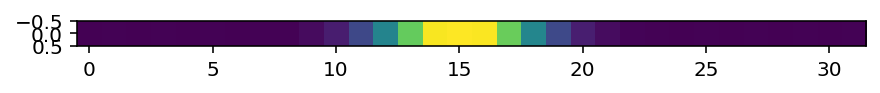

In [32]:
torch.manual_seed(0)
simulator = PlaceGridMotionSimulator(32, sigma=2)

fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(simulator()[None, :])

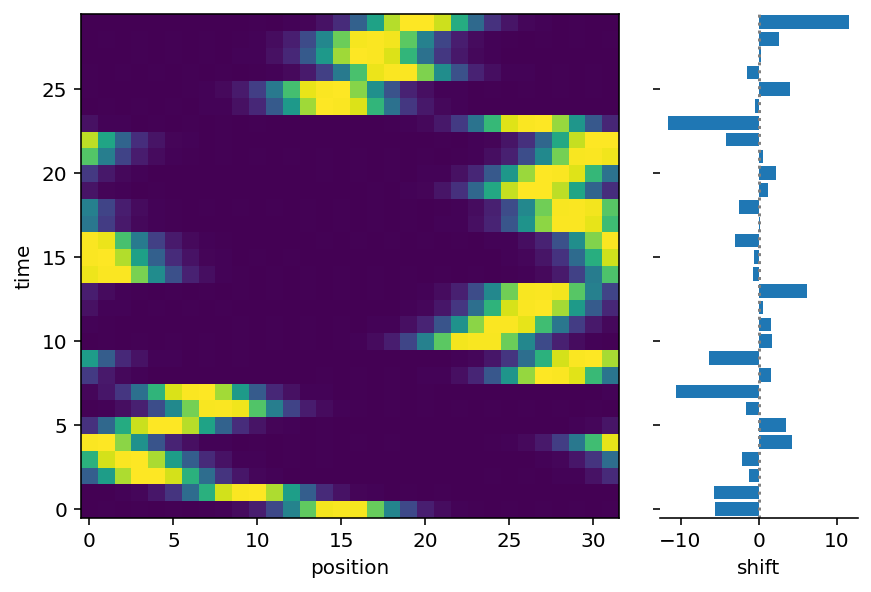

In [33]:
torch.manual_seed(0)
simulator = PlaceGridMotionSimulator(32, sigma=2)

crt_s = torch.normal(torch.zeros(30), 5.0)
crt_batch = simulator.batch(crt_s)

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(crt_batch)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=crt_s, y=np.arange(len(crt_s)))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

## Try some learning

In [34]:
torch.manual_seed(0)

n = 32
simulator = PlaceGridMotionSimulator(n, sigma=2)

n_samples = 150_000
s = torch.normal(torch.zeros(n_samples), 5.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 500
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

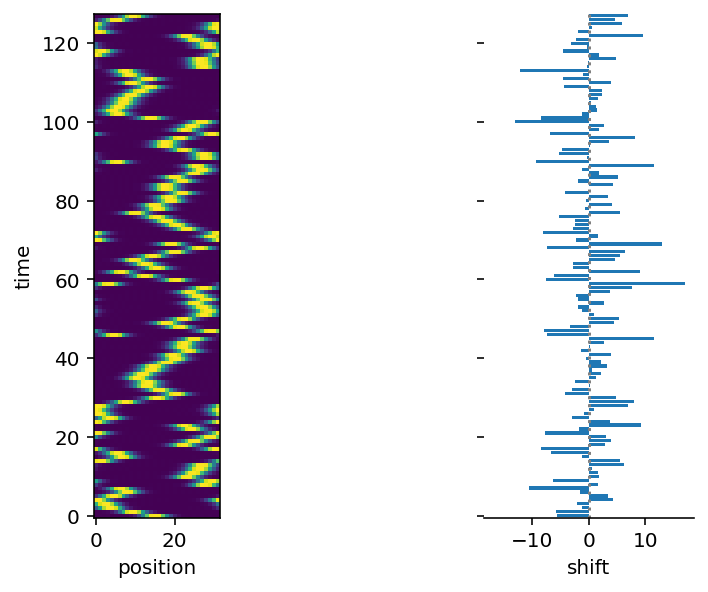

In [35]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

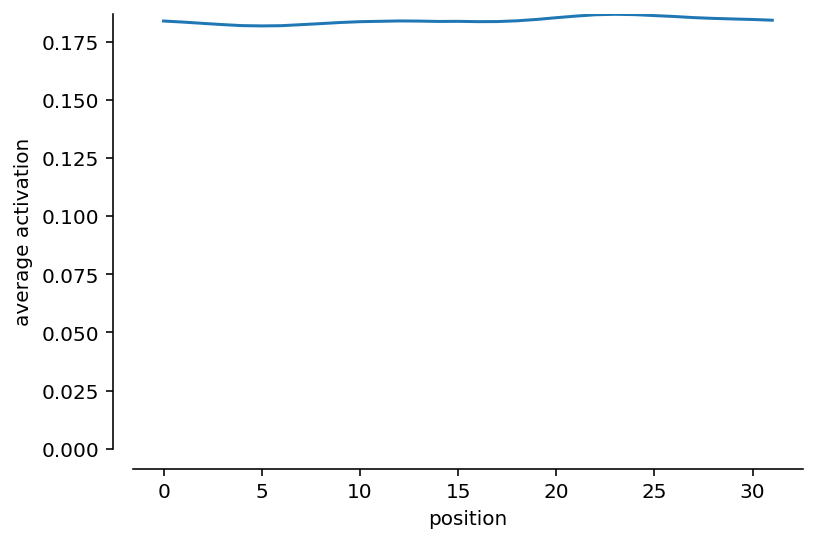

In [36]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Check that the generated patterns exactly match Fourier translations

In [37]:
crt_fourier_U = np.array(
    [
        [1 / np.sqrt(n) * np.exp(2 * np.pi * k * l / n * 1j) for k in range(n)]
        for l in range(n)
    ]
)
crt_fourier_V = crt_fourier_U.conj().T

In [38]:
(
    np.max(np.abs(crt_fourier_U @ crt_fourier_V - np.eye(n))),
    np.max(np.abs(crt_fourier_V @ crt_fourier_U - np.eye(n))),
)

(3.243653198645024e-15, 4.099017829071558e-15)

In [39]:
def fourier_translate(x: Sequence, s: float) -> np.ndarray:
    n = len(x)
    # turns out the ** operator has the right branch cut to maket this work
    lbd = np.exp(-(2j * np.pi / n) * np.arange(n)) ** s

    # need to zero out highest frequency mode if n is even
    if n % 2 == 0:
        lbd[n // 2] = 0

    x_f = crt_fourier_V @ x
    x_f_shifted = lbd * x_f
    x_shifted = crt_fourier_U @ x_f_shifted
    
    assert np.max(np.abs(x_shifted.imag)) < 1e-6

    return x_shifted.real

In [40]:
crt_errors = []
for x, y, s in dataset_full:
    x = x.detach().numpy()
    y = y.detach().numpy()
    s = s.item()

    y_pred = fourier_translate(x, s)
    crt_errors.append(np.linalg.norm(y - y_pred))

crt_errors = np.array(crt_errors)

In [41]:
np.quantile(crt_errors, [0.005, 0.025, 0.500, 0.975, 0.995])

array([2.56738032e-08, 3.22489899e-08, 5.83681339e-08, 8.50016990e-08,
       9.26411670e-08])

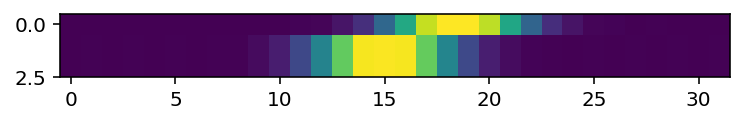

In [42]:
plt.imshow(np.vstack((x, y, y_pred)))

### Checks for complex-valued version

#### Check that a model initialized at Fourier solution yields (almost) zero loss

In [43]:
test_system = PlaceGridSystemNonBioCplx(n, n - 1)
sys_U_torch = torch.from_numpy(np.copy(crt_fourier_V.T)).type(torch.complex64)
sys_V_torch = torch.from_numpy(np.copy(crt_fourier_U.T)).type(torch.complex64)
test_system.U = torch.hstack((sys_U_torch[:, : n // 2], sys_U_torch[:, n // 2 + 1 :]))
test_system.V = torch.vstack((sys_V_torch[: n // 2, :], sys_V_torch[n // 2 + 1 :, :]))

crt_lbd = torch.exp(-(2j * np.pi / n) * torch.arange(n))
test_system.lbd = torch.hstack((crt_lbd[: n // 2], crt_lbd[n // 2 + 1 :]))

# this doesn't really matter for the math, but for consistency: let's put c.c. pairs
# next to each other
crt_order = torch.hstack(
    (
        torch.IntTensor([0]),
        torch.stack(
            (torch.arange(1, n // 2), torch.arange(n - 2, n // 2 - 1, - 1))
        ).T.ravel(),
    )
)
test_system.U = test_system.U[:, crt_order]
test_system.V = test_system.V[crt_order, :]
test_system.lbd = test_system.lbd[crt_order]

crt_scores = []
for x, y, s in dataset_full:
    crt_loss = test_system.loss(x[None, :], y[None, :], s[None]).item()
    crt_scores.append(crt_loss)

crt_scores = np.array(crt_scores)

In [44]:
np.quantile(crt_scores, [0.005, 0.025, 0.500, 0.975, 0.995])

array([9.52767273e-16, 1.32039151e-15, 3.85195009e-15, 1.40938814e-14,
       2.13055398e-14])

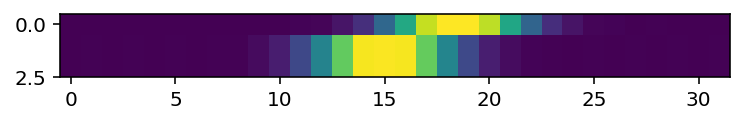

In [45]:
y_pred = test_system.propagate_place(x[None, :], s[None])
plt.imshow(np.vstack((x, y, y_pred)))

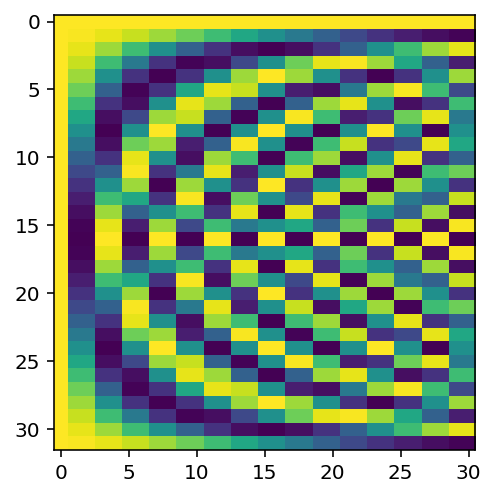

In [46]:
plt.imshow(test_system.U.real)

#### Sanity check: projection to valid parameters does not spoil global optimum

In [47]:
crt_old_U = torch.clone(test_system.U)
crt_old_V = torch.clone(test_system.V)
crt_old_lbd = torch.clone(test_system.lbd)

test_system.project_to_real()

assert torch.allclose(crt_old_U, test_system.U)
assert torch.allclose(crt_old_V, test_system.V)
assert torch.allclose(crt_old_lbd, test_system.lbd)

#### Sanity check: gradient (almost) zero at global optimum

In [48]:
test_system.U.requires_grad = True
test_system.V.requires_grad = True
test_system.lbd.requires_grad = True

test_system.train()

crt_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=200)
crt_iter = iter(crt_dataloader)
crt_data, crt_target, crt_shift = next(crt_iter)

test_system.zero_grad()
crt_loss = test_system.loss(crt_data, crt_target, crt_shift)
crt_loss.backward()

assert torch.max(torch.abs(crt_loss)) < 1e-9

assert torch.max(torch.abs(test_system.U.grad)) < 1e-9
assert torch.max(torch.abs(test_system.V.grad)) < 1e-9
assert torch.max(torch.abs(test_system.lbd.grad)) < 1e-6

#### Sanity check: SGD optimization does not lead us away from global optimum

In [49]:
batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

test_system.U.requires_grad = True
test_system.V.requires_grad = True
test_system.lbd.requires_grad = True

test_optimizer = torch.optim.SGD(test_system.parameters(), lr=0.001)
test_scheduler = torch.optim.lr_scheduler.StepLR(
    test_optimizer, step_size=10, gamma=0.995
)
test_train_results = train(
    test_system,
    "cpu",
    dataloader_train,
    test_optimizer,
    test_set=dataloader_test,
    test_every=200,
    scheduler=test_scheduler,
)

100%|████████████████████| 149499/149499 [00:01<00:00, 76268.15it/s, train batch loss: 0.000000]


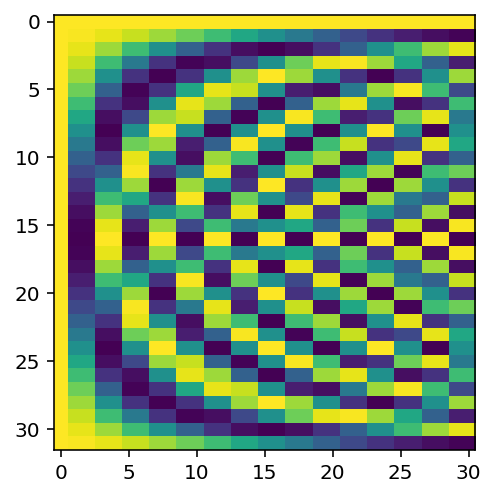

In [50]:
plt.imshow(test_system.U.real.detach())

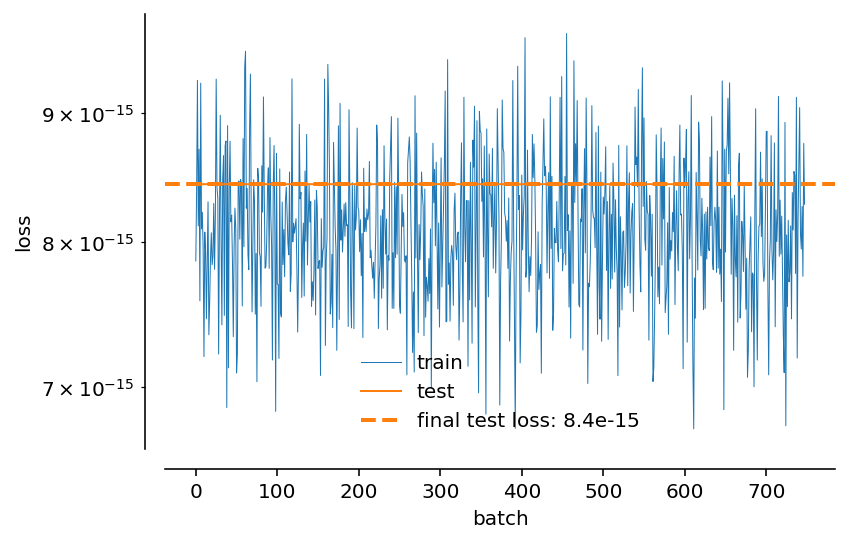

In [51]:
fig, ax = plt.subplots()
ax.semilogy(test_train_results.train_loss, lw=0.5, label="train")
ax.semilogy(
    test_train_results.test_idxs, test_train_results.test_loss, lw=1.0, label="test"
)
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    test_train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {test_train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

### Checks for real-valued version

### Run learning for complex-valued version

In [52]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBioCplx(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_lbd = torch.clone(system.lbd).detach()

optimizer = torch.optim.Adagrad(system.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
scheduler = StepwiseScheduler(optimizer, [(50, 0.05), (100, 0.2), (100, 0.3), (250, 0.1)])

train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|████████████████████| 149499/149499 [00:01<00:00, 79743.08it/s, train batch loss: 0.003351]


In [53]:
scheduler.get_last_lr()

[0.1]

In [54]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.lbd - original_lbd)),
)

(tensor(0.1479, grad_fn=<MedianBackward0>),
 tensor(0.1519, grad_fn=<MedianBackward0>),
 tensor(0.1347, grad_fn=<MedianBackward0>))

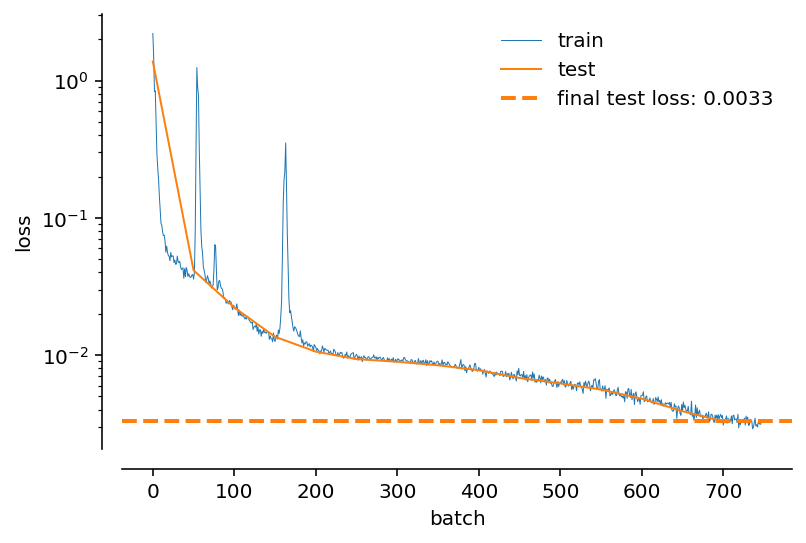

In [55]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

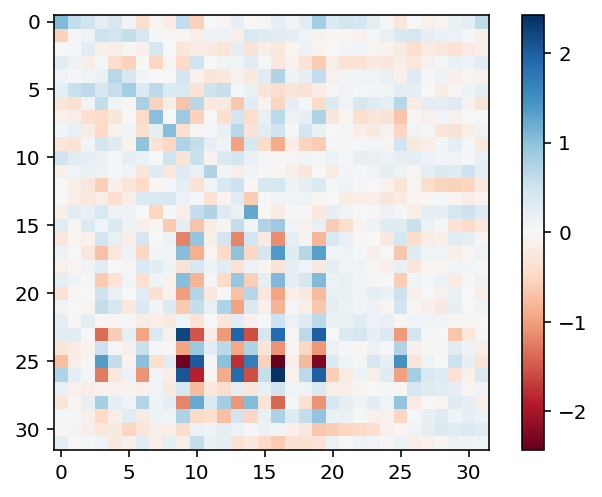

In [56]:
crt_tensor = torch.real(system.U @ system.V).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

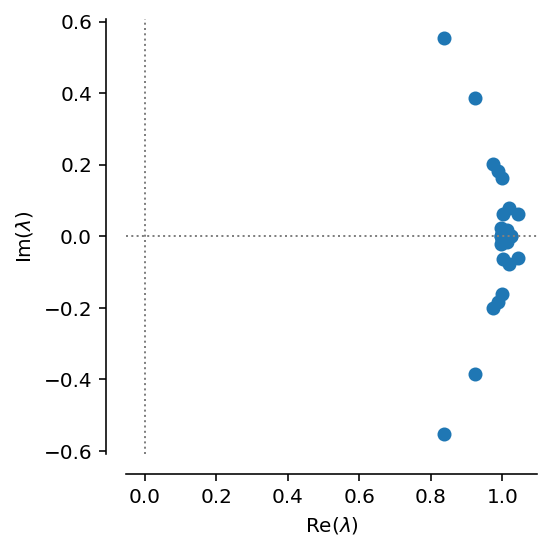

In [57]:
fig, ax = plt.subplots()
crt_v = system.lbd.detach().numpy()

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [58]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(2.4618, grad_fn=<MaxBackward1>),
 tensor(1.5037, grad_fn=<MaxBackward1>))

#### Try learned system on examples

In [59]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=2)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [60]:
test_moved = system.propagate_place(test_trajectory, 3 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

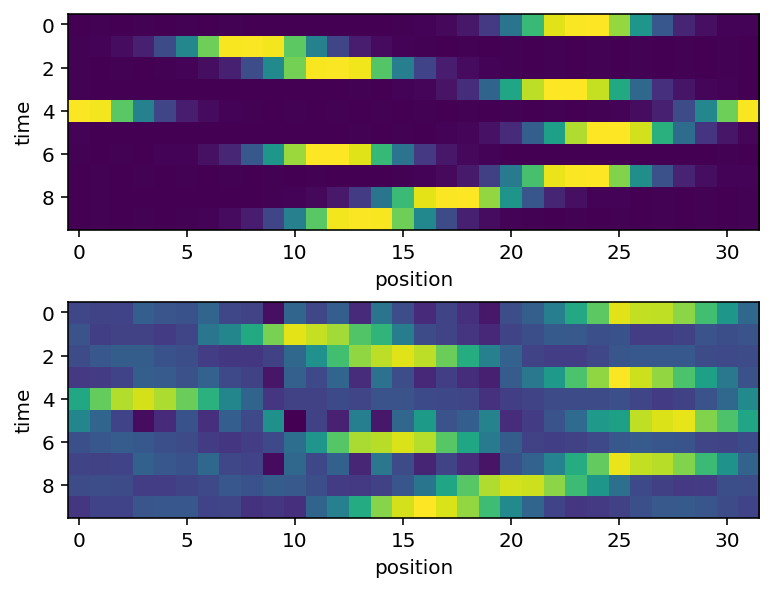

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [62]:
[torch.min(torch.abs(system.lbd)), torch.max(torch.abs(system.lbd))]

[tensor(0.9937, grad_fn=<MinBackward1>),
 tensor(1.0463, grad_fn=<MaxBackward1>)]

Text(0.5, 0, 'Im')

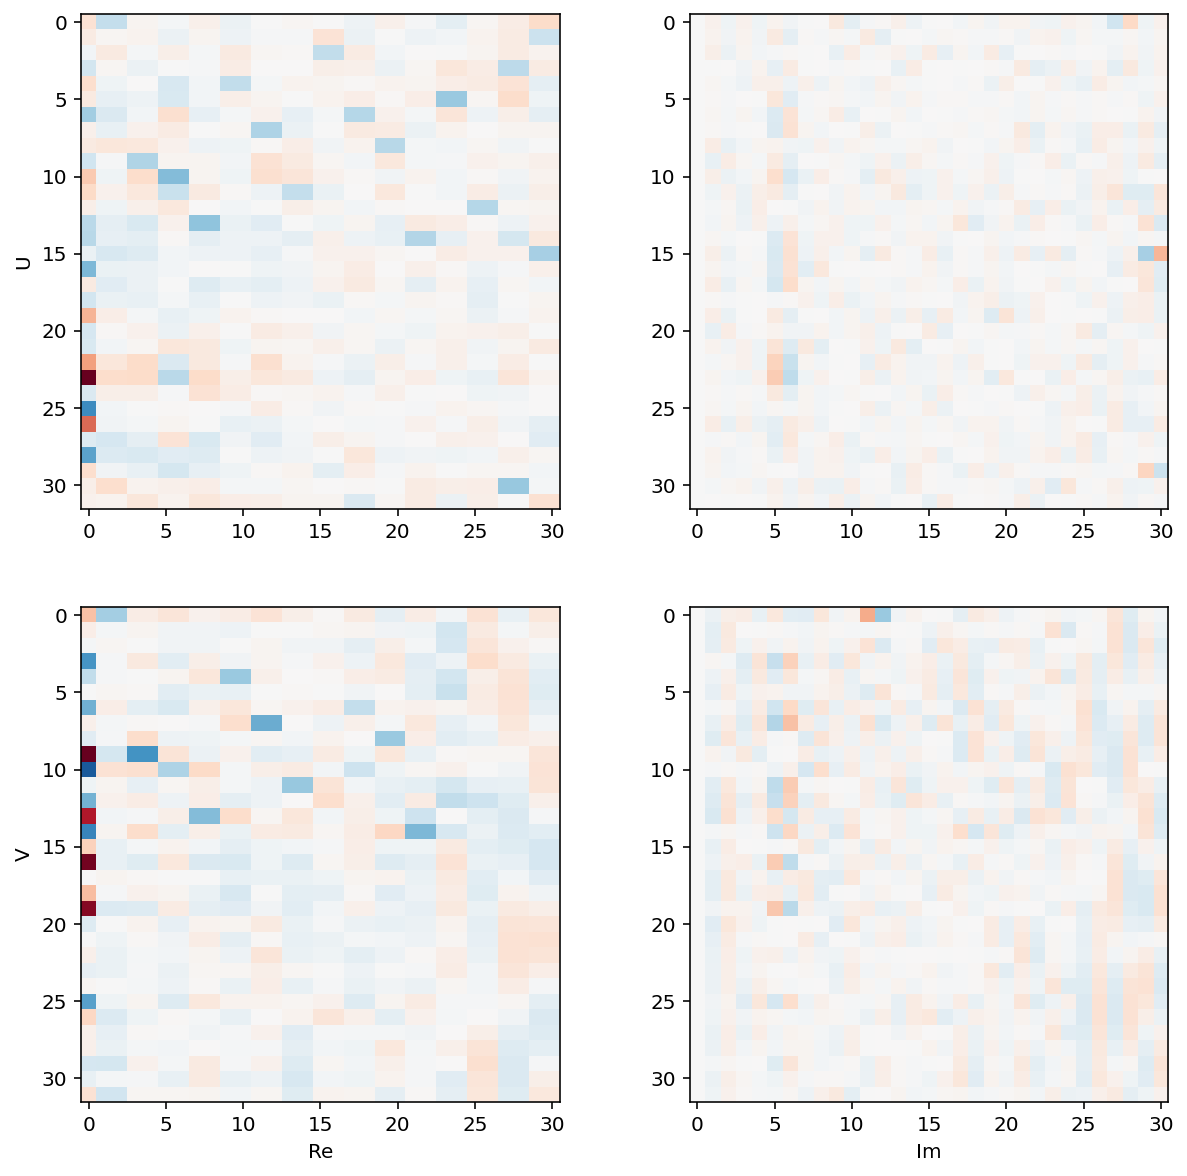

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
crt_d = {"U": system.U, "V": system.V.T}
crt_ordering = np.argsort(np.abs(np.angle(system.lbd.detach().numpy())))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))

    ax_row = axs[i]
    ax_row[0].imshow(crt_mat.real, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")
    ax_row[1].imshow(crt_mat.imag, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax_row[0].set_ylabel(crt_name)

axs[1, 0].set_xlabel("Re")
axs[1, 1].set_xlabel("Im")

### Run learning for real-valued version

In [64]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.Adagrad(system.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(optimizer, [(50, 0.05), (100, 0.2), (100, 0.3), (250, 0.1)])
scheduler = None

train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████████████████| 149499/149499 [06:04<00:00, 409.61it/s, train batch loss: 0.001712]


In [65]:
# scheduler.get_last_lr()

In [66]:
(
    torch.max(torch.abs(system.U - original_U)),
    torch.max(torch.abs(system.V - original_V)),
    torch.max(torch.abs(system.xi - original_xi)),
    torch.max(torch.abs(system.theta - original_theta)),
)

(tensor(0.3685, grad_fn=<MaxBackward1>),
 tensor(0.8416, grad_fn=<MaxBackward1>),
 tensor(0.2032, grad_fn=<MaxBackward1>),
 tensor(0.5329, grad_fn=<MaxBackward1>))

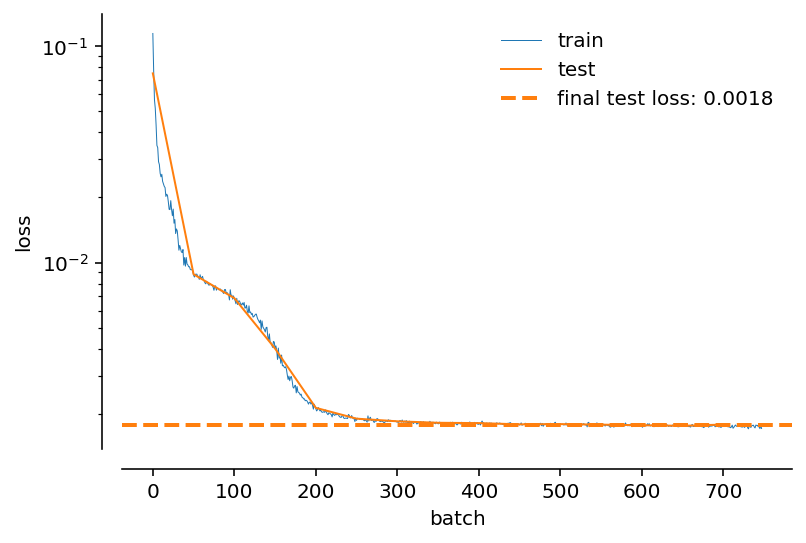

In [67]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

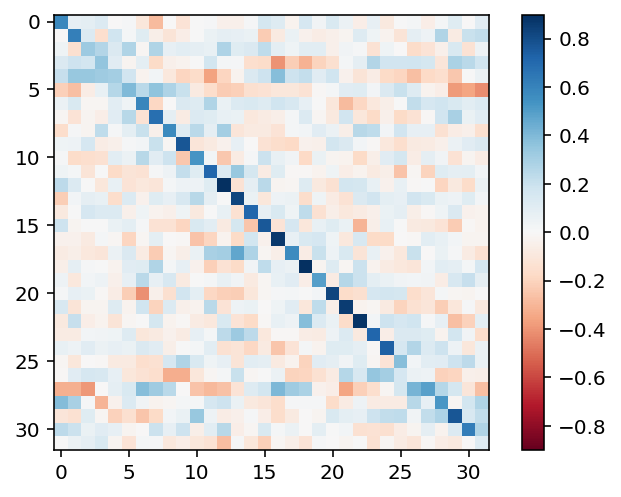

In [68]:
crt_tensor = (system.U @ system.V).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

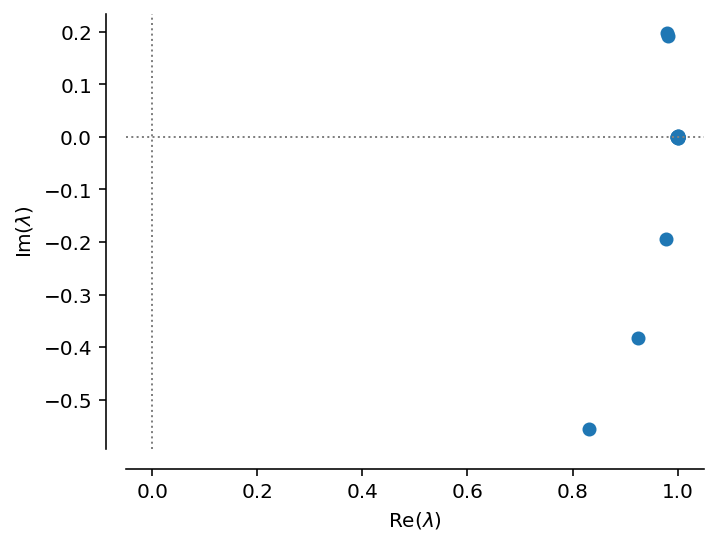

In [69]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [70]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(1.0242, grad_fn=<MaxBackward1>),
 tensor(1.0650, grad_fn=<MaxBackward1>))

#### Try learned system on examples

In [71]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=2)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [72]:
test_moved = system.propagate_place(test_trajectory, 3 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

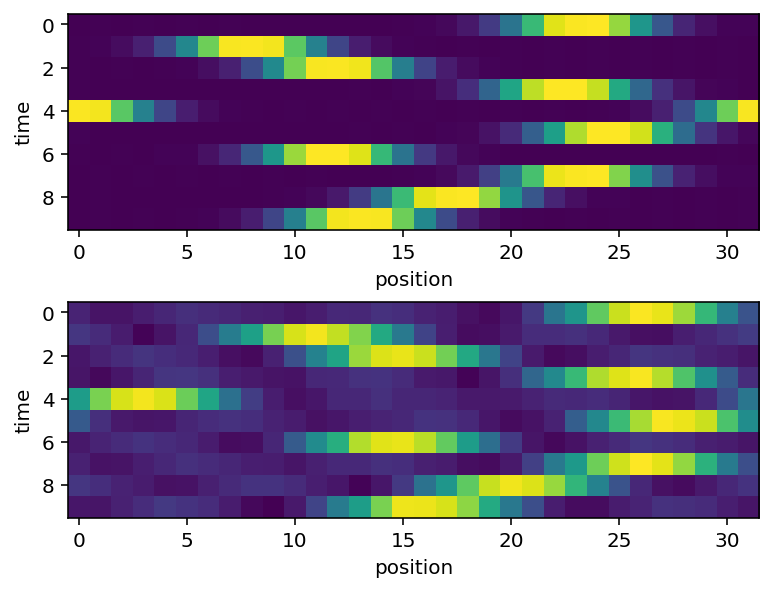

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [74]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(1.4356e-18, grad_fn=<MinBackward1>),
 tensor(0.0854, grad_fn=<MaxBackward1>)]

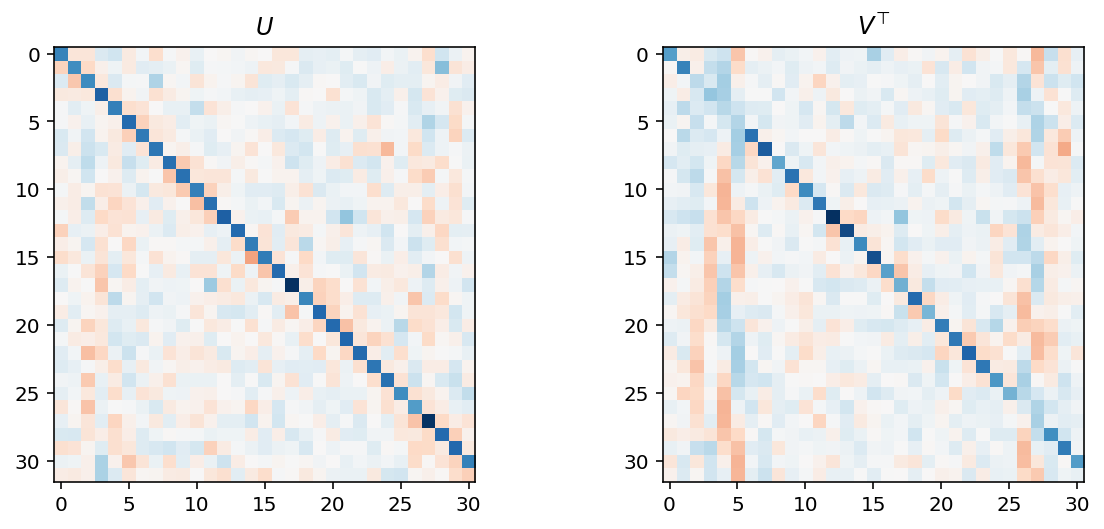

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U$": system.U, "$V^\\top$": system.V.T}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

In [76]:
1 / np.cosh(system.xi.detach().numpy())

array([1.        , 0.9999931 , 1.        , 0.9998301 , 0.9999168 ,
       0.9963665 , 0.9994288 , 0.99999976, 0.99992144, 0.99959785,
       0.9991146 , 0.9997801 , 0.9999018 , 0.99966764, 1.        ,
       1.        ], dtype=float32)

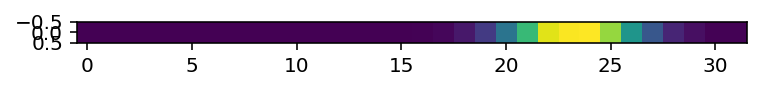

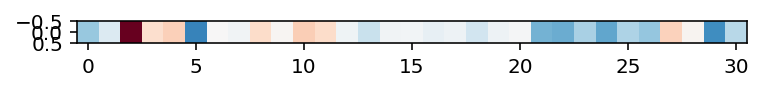

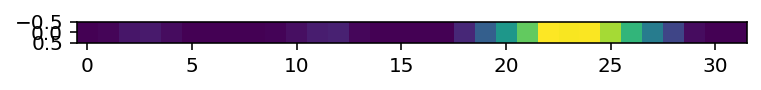

In [77]:
tmp = test_trajectory[0]
tmp_g = system.to_grid(tmp)
fig, ax = plt.subplots()
ax.imshow([tmp.numpy()], vmin=0)

fig, ax = plt.subplots()
crt_l = np.max(np.abs(tmp_g.detach().numpy()))
ax.imshow([tmp_g.detach().numpy()], vmin=-crt_l, vmax=crt_l, cmap="RdBu")

tmp_back = system.from_grid(tmp_g)
fig, ax = plt.subplots()
ax.imshow([tmp_back.detach().numpy()], vmin=0)

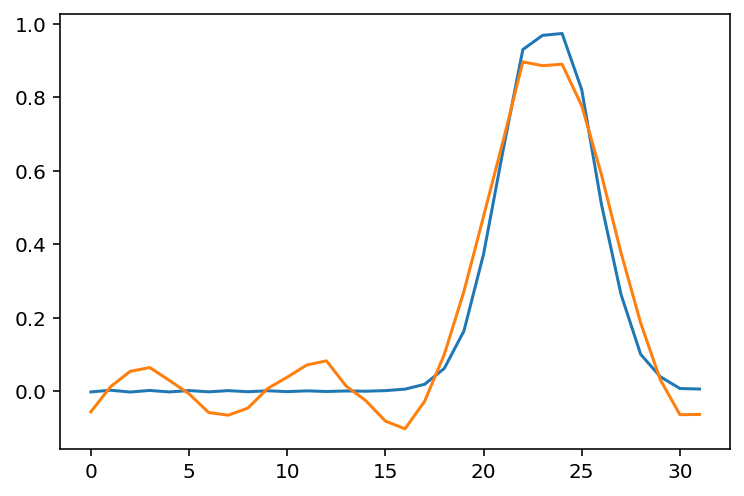

In [78]:
fig, ax = plt.subplots()
ax.plot(tmp.detach().numpy())
ax.plot(tmp_back.detach().numpy())

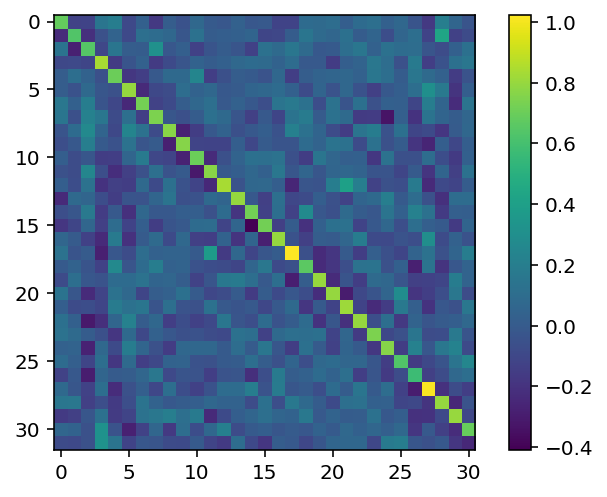

In [79]:
plt.imshow(system.U.detach().numpy())
plt.colorbar()

## Test learning on smaller system

In [80]:
torch.manual_seed(0)

n = 8
simulator = PlaceGridMotionSimulator(n, sigma=0.5)

n_samples = 500_000
s = torch.normal(torch.zeros(n_samples), 1.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 1000
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

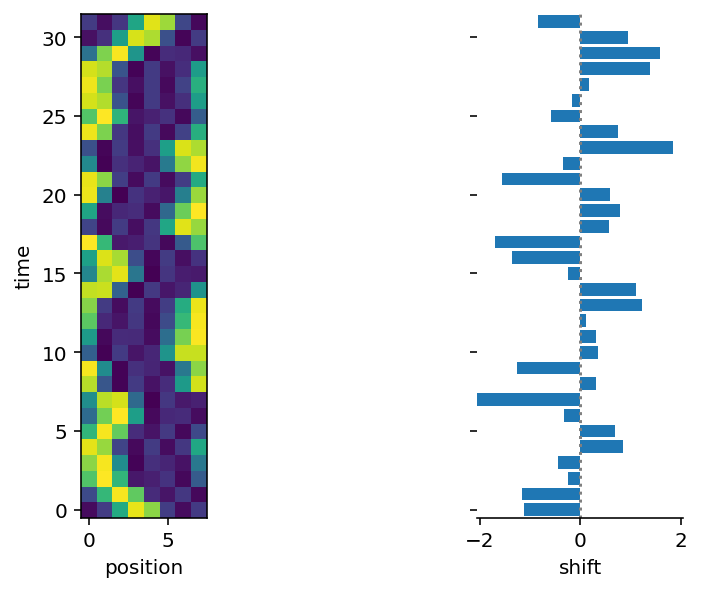

In [81]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

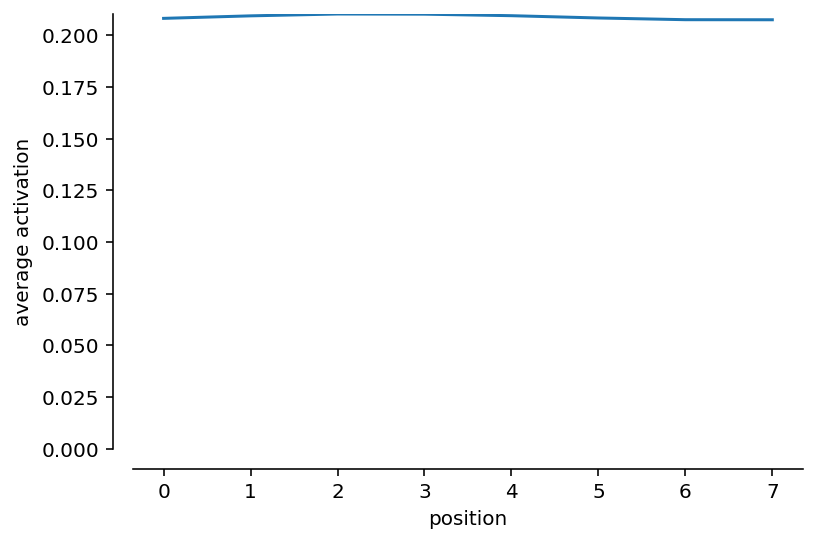

In [82]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Complex-valued simulation

In [83]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBioCplx(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_lbd = torch.clone(system.lbd).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
scheduler = StepwiseScheduler(
    optimizer,
    [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
)
# scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|████████████████████| 498999/498999 [00:05<00:00, 99285.54it/s, train batch loss: 0.000509]


In [84]:
scheduler.get_last_lr()

[0.005]

In [85]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.lbd - original_lbd)),
)

(tensor(0.4251, grad_fn=<MedianBackward0>),
 tensor(0.4127, grad_fn=<MedianBackward0>),
 tensor(0.6682, grad_fn=<MedianBackward0>))

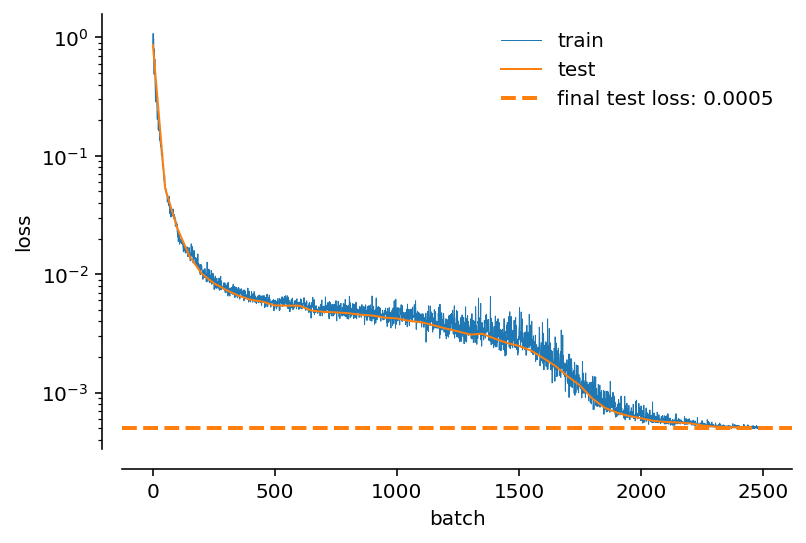

In [86]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

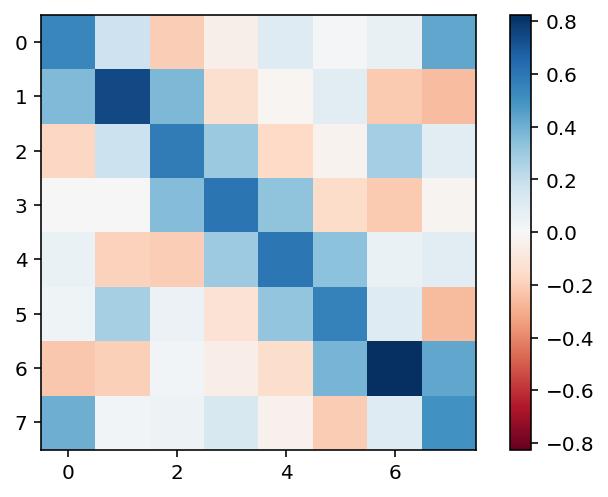

In [87]:
crt_tensor = torch.real(system.U @ system.V).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

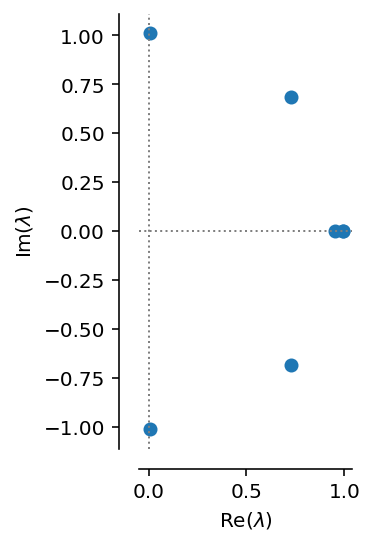

In [88]:
fig, ax = plt.subplots()
crt_v = system.lbd.detach().numpy()

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [89]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.7051, grad_fn=<MaxBackward1>),
 tensor(1.8093, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [90]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [91]:
test_moved = system.propagate_place(test_trajectory, 1 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

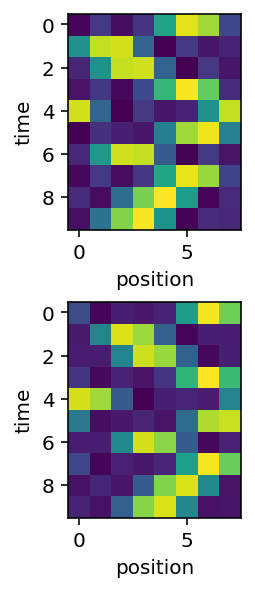

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [93]:
[torch.min(torch.abs(system.lbd)), torch.max(torch.abs(system.lbd))]

[tensor(0.9524, grad_fn=<MinBackward1>),
 tensor(1.0099, grad_fn=<MaxBackward1>)]

Text(0.5, 0, 'Im')

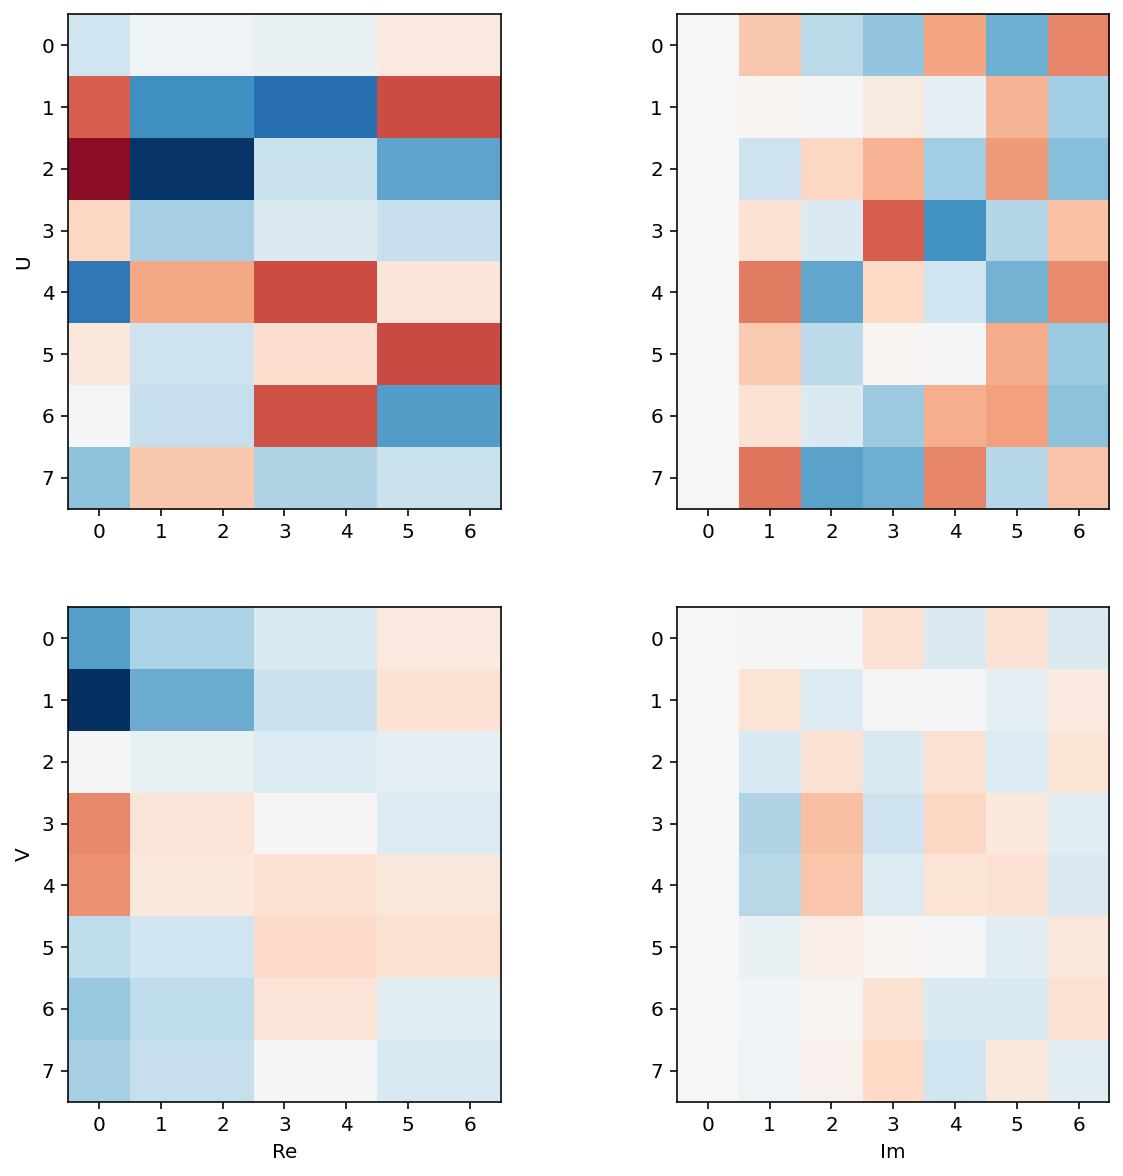

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
crt_d = {"U": system.U, "V": system.V.T}
crt_ordering = np.argsort(np.abs(np.angle(system.lbd.detach().numpy())))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))

    ax_row = axs[i]
    ax_row[0].imshow(crt_mat.real, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")
    ax_row[1].imshow(crt_mat.imag, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax_row[0].set_ylabel(crt_name)

axs[1, 0].set_xlabel("Re")
axs[1, 1].set_xlabel("Im")

### Real-valued simulation

In [95]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(
#     optimizer,
#     [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
# )
scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|█████████████████████| 498999/498999 [06:00<00:00, 1382.35it/s, train batch loss: 0.000000]


In [96]:
# scheduler.get_last_lr()

In [97]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.xi - original_xi)),
    torch.median(torch.abs(system.theta - original_theta)),
)

(tensor(0.3139, grad_fn=<MedianBackward0>),
 tensor(0.3289, grad_fn=<MedianBackward0>),
 tensor(0.0768, grad_fn=<MedianBackward0>),
 tensor(1.6255, grad_fn=<MedianBackward0>))

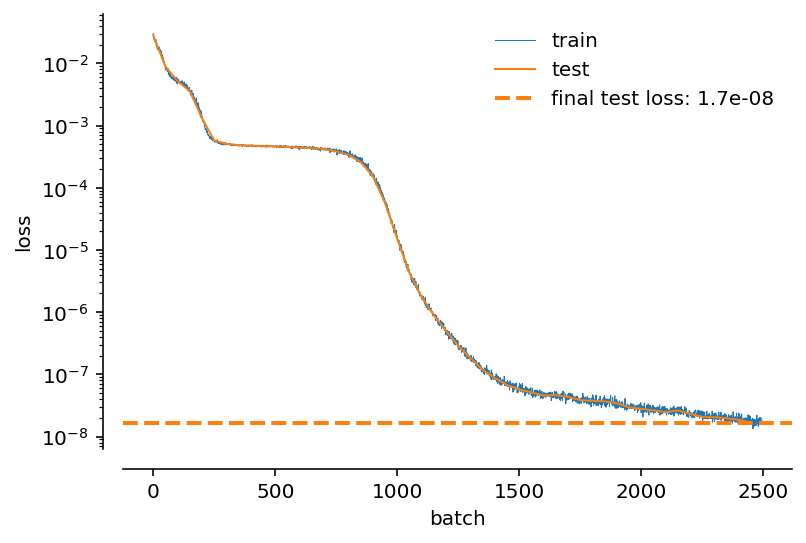

In [98]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

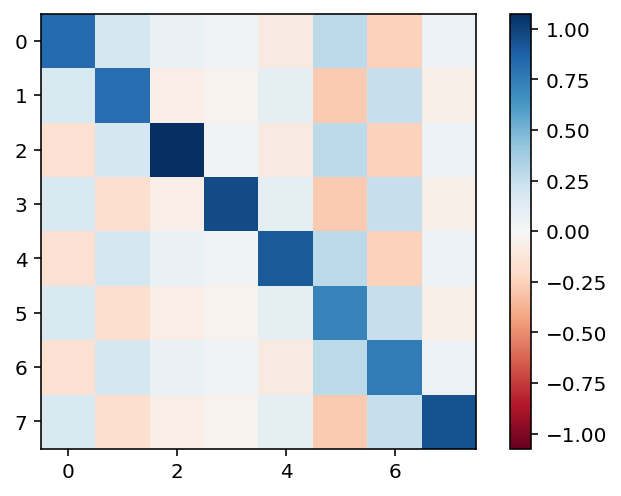

In [99]:
crt_tensor = (system.U @ system.V).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

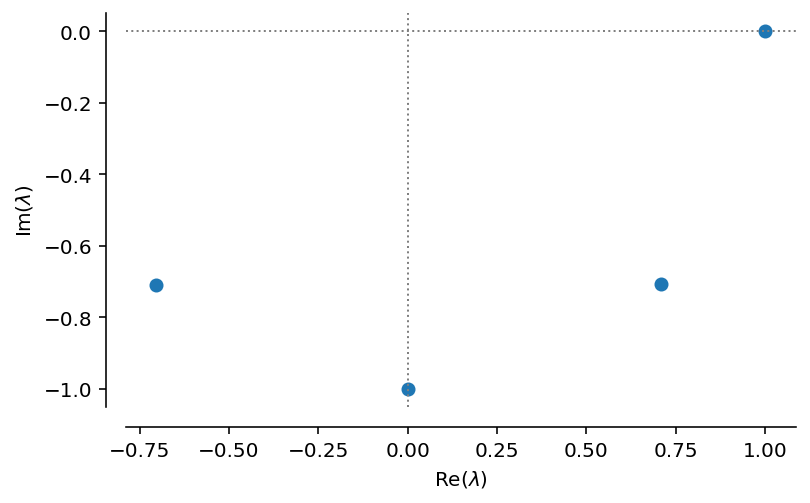

In [100]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [101]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.6064, grad_fn=<MaxBackward1>),
 tensor(0.5552, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [102]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [103]:
test_moved = system.propagate_place(test_trajectory, 1 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

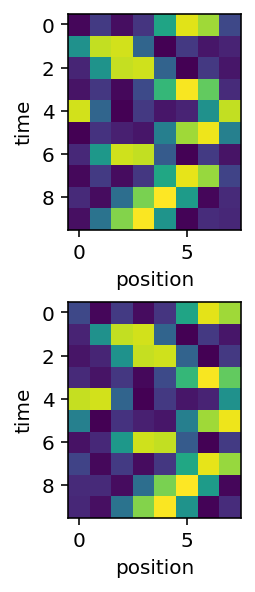

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [105]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(4.4201e-07, grad_fn=<MinBackward1>),
 tensor(0.0277, grad_fn=<MaxBackward1>)]

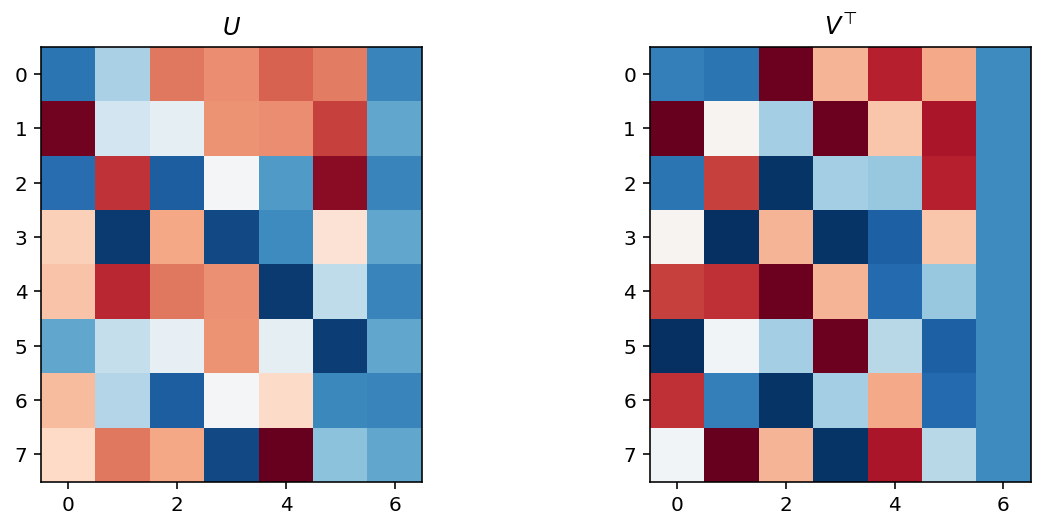

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U$": system.U, "$V^\\top$": system.V.T}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

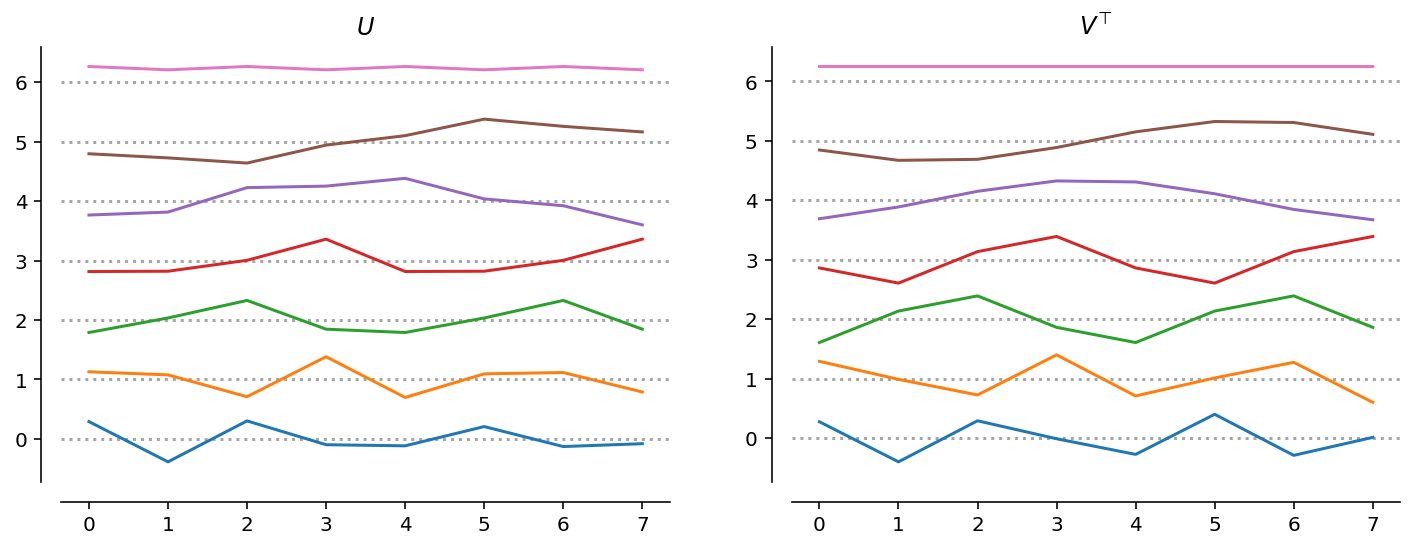

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
crt_d = {"$U$": system.U, "$V^\\top$": system.V.T}
for i, crt_name in enumerate(crt_d):
    ax = axs[i]
    crt_mat = crt_d[crt_name].detach().numpy()
    crt_lim = np.max(np.abs(crt_mat))
    for k in range(m):
        crt_v = crt_mat[:, k]
        ax.axhline(k, ls=":", c="gray", alpha=0.7)
        ax.plot(np.arange(n), k + 0.4 * crt_v / crt_lim)
    
    ax.set_title(crt_name)
    sns.despine(ax=ax, offset=10)

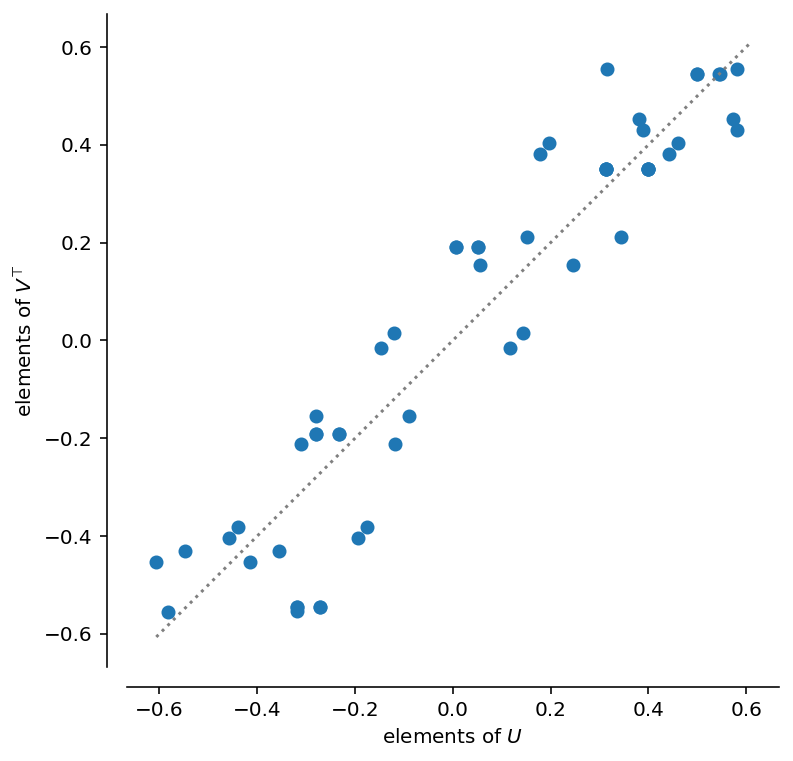

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))
crt_u = system.U.detach().numpy()
crt_vt = system.V.T.detach().numpy()
crt_lim = max(np.max(np.abs(_)) for _ in [crt_u, crt_vt])
ax.plot([-crt_lim, crt_lim], [-crt_lim, crt_lim], c="gray", ls=":")
ax.scatter(crt_u, crt_vt)
ax.set_xlabel("elements of $U$")
ax.set_ylabel("elements of $V^\\top$")

ax.set_aspect(1)
sns.despine(ax=ax, offset=10)

## Check Fourier translation on von-Mises

In [109]:
n = 8
fourier_U = np.array(
    [
        [1 / np.sqrt(n) * np.exp(2 * np.pi * k * l / n * 1j) for k in range(n)]
        for l in range(n)
    ]
)
fourier_V = fourier_U.conj().T

In [110]:
(
    np.max(np.abs(fourier_U @ fourier_V - np.eye(n))),
    np.max(np.abs(fourier_V @ fourier_U - np.eye(n))),
)

(6.983441715775668e-16, 6.983441715775668e-16)

In [111]:
def fourier_translate(x: Sequence, s: float) -> np.ndarray:
    n = len(x)
    # turns out the ** operator has the right branch cut to maket this work
    lbd = np.exp(-(2j * np.pi / n) * np.arange(n)) ** s

    # need to zero out highest frequency mode if n is even
    if n % 2 == 0:
        lbd[n // 2] = 0

    x_f = fourier_V @ x
    x_f_shifted = lbd * x_f
    x_shifted = fourier_U @ x_f_shifted
    
    assert np.max(np.abs(x_shifted.imag)) < 1e-6

    return x_shifted.real

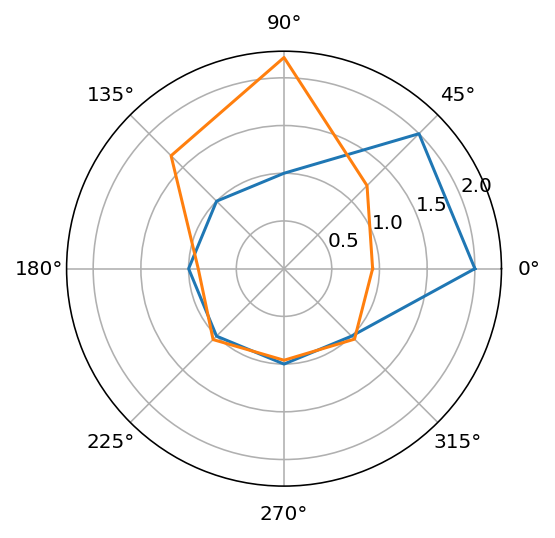

In [112]:
crt_s = 1.7
crt_v0 = np.hstack(([1, 1], np.zeros(n - 2)))
crt_v1 = fourier_translate(crt_v0, crt_s)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v0, crt_v0[[0]])), c="C0")
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v1, crt_v1[[0]])), c="C1")

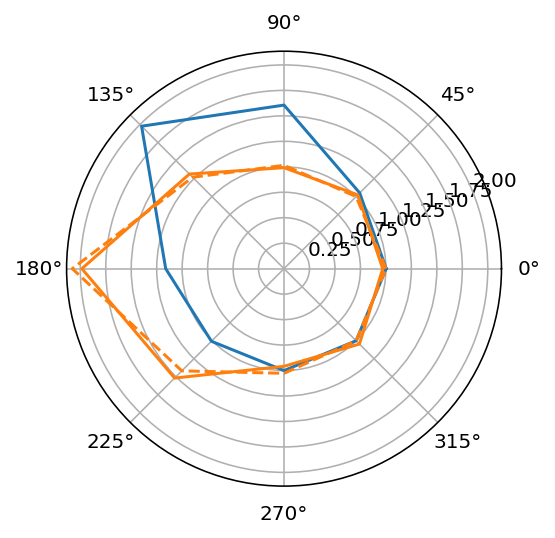

In [113]:
crt_x0 = 2.7
crt_cos = np.cos(2 * np.pi * (np.arange(n) - crt_x0) / n)
crt_kappa = 1 / 0.5 ** 2
crt_v0 = 0.02 * np.exp(crt_kappa * crt_cos)

crt_s = 1.4
crt_v1 = fourier_translate(crt_v0, crt_s)

# what if we had shifted the von Mises?
crt_cos_tgt = np.cos(2 * np.pi * (np.arange(n) - crt_x0 - crt_s) / n)
crt_v1_tgt = 0.02 * np.exp(crt_kappa * crt_cos_tgt)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v0, crt_v0[[0]])), c="C0")
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v1, crt_v1[[0]])), c="C1")
ax.plot(
    np.arange(n + 1) / n * 2 * np.pi,
    1 + np.hstack((crt_v1_tgt, crt_v1_tgt[[0]])),
    c="C1",
    ls="--",
)

In [114]:
np.max(np.abs(crt_v1 - crt_v1_tgt))

0.1000961005125568